# Bayesian Belief Networks

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

I have used a dataset from kaggle (https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset) which has attributes N (Nitrogen), P (Phosphorous), K (Potassium), Temperature, ph, rainfall and which crop will be the best based on that conditons. 

In [2]:
df = pd.read_csv('./Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [4]:
df_desc = df.describe()
df_desc

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


Converting continous values into categorical as it will be easier to understand and visuilize the probabilities in bayesian networks.

In [5]:
def convert_into_categorical(column_name, x):
    quartile_2 = df_desc[column_name]['25%']
    quartile_3 = df_desc[column_name]['75%']
    if(x<quartile_2):
        return 'low'
    elif(x>quartile_2 and x<quartile_3):
        return 'medium'
    else:
        return 'high'

In [6]:
df['N'] = df['N'].apply(lambda x: convert_into_categorical('N', x))
df['P'] = df['P'].apply(lambda x: convert_into_categorical('P', x))
df['K'] = df['K'].apply(lambda x: convert_into_categorical('K', x))
df['temperature'] = df['temperature'].apply(lambda x: convert_into_categorical('temperature', x))
df['humidity'] = df['humidity'].apply(lambda x: convert_into_categorical('humidity', x))
df['ph'] = df['ph'].apply(lambda x: convert_into_categorical('ph', x))
df['rainfall'] = df['rainfall'].apply(lambda x: convert_into_categorical('rainfall', x))

In [7]:
df

,N,P,K,temperature,humidity,ph,rainfall,label
0,high,medium,medium,low,medium,medium,high,rice
1,high,medium,medium,low,medium,high,high,rice
2,medium,medium,medium,medium,medium,high,high,rice
3,medium,medium,medium,medium,medium,high,high,rice
4,medium,medium,medium,low,medium,high,high,rice
...,...,...,...,...,...,...,...,...
2195,high,medium,medium,medium,medium,medium,high,coffee
2196,high,low,medium,medium,low,medium,high,coffee
2197,high,medium,medium,medium,medium,medium,high,coffee
2198,high,medium,medium,medium,low,medium,high,coffee


In [8]:
df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [9]:
df.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

## Making a Bayesian network

In [10]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

Getting the probabilities

In [11]:
df['N'].value_counts().sort_index() / len(df)

high      0.262727
low       0.243636
medium    0.493636
Name: N, dtype: float64

In [12]:
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            if parent2==None:
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else:
        print("Error in Probability Frequency Calculations")
        
    return prob  

In [13]:
probs(df, 'N')

[0.26272727272727275, 0.24363636363636362, 0.49363636363636365]

In [14]:
df['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [15]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,high,medium,medium,low,medium,medium,high,rice
1,high,medium,medium,low,medium,high,high,rice
2,medium,medium,medium,medium,medium,high,high,rice
3,medium,medium,medium,medium,medium,high,high,rice
4,medium,medium,medium,low,medium,high,high,rice


In [16]:
df.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')

Here I have added the relations that N, P, K and temperature are independent. humidity depends on temperature. ph depend on N and P. Rainfall depends on temperatue and humidity, Finally Crop depends on ph and rainfall. 

In [17]:
from pybbn.graph.factory import Factory

structure = {
    'N': [],
    'P': [],
    'K': [],
    'temperature': [],
    'humidity': ['temperature'],
    'ph': ['N', 'P'],
    'rainfall': ['temperature', 'humidity'],
    'label': ['ph', 'rainfall']
}

bbn = Factory.from_data(structure, df)

In [18]:
from pybbn.pptc.inferencecontroller import InferenceController

join_tree = InferenceController.apply(bbn)

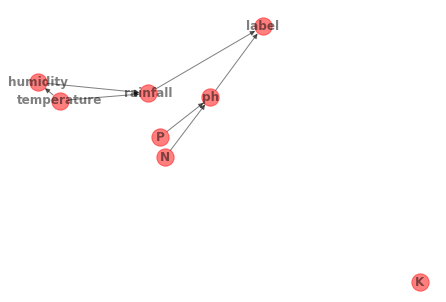

In [19]:
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, node_color='r', alpha=0.5, font_weight='bold')
plt.show()

In [20]:
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')

Now we will first find the probabilities of the default values with no additional inference given.

In [21]:
print_probs()

Node: 27|K|high,low,medium
Values:
27=high|0.28773
27=low|0.21727
27=medium|0.49500
----------------
Node: 26|P|high,low,medium
Values:
26=high|0.26636
26=low|0.24545
26=medium|0.48818
----------------
Node: 30|ph|high,low,medium
Values:
30=high|0.24679
30=low|0.26019
30=medium|0.49302
----------------
Node: 25|N|high,low,medium
Values:
25=high|0.26273
25=low|0.24364
25=medium|0.49364
----------------
Node: 29|humidity|high,low,medium
Values:
29=high|0.25000
29=low|0.25000
29=medium|0.50000
----------------
Node: 31|rainfall|high,low,medium
Values:
31=high|0.24491
31=low|0.25164
31=medium|0.50345
----------------
Node: 28|temperature|high,low,medium
Values:
28=high|0.25000
28=low|0.25000
28=medium|0.50000
----------------
Node: 32|label|apple,banana,blackgram,chickpea,coconut,coffee,cotton,grapes,jute,kidneybeans,lentil,maize,mango,mothbeans,mungbean,muskmelon,orange,papaya,pigeonpeas,pomegranate,rice,watermelon
Values:
32=apple|0.04309
32=banana|0.04444
32=blackgram|0.04607
32=chickpe

Best crop to grow when no conditions are given is "mothbeans" as it has the highest probablity

In [22]:
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

Now we can assume that a certain evidence is given and add that observation into our join_tree and then print the probabilities.

In [23]:
#Let us assume N is high and temperature is low (Given as true so value is 1)
evidence('ev1', 'N', 'high', 1)
evidence('ev2', 'temperature', 'low', 1)
print_probs()

Node: 27|K|high,low,medium
Values:
27=high|0.28773
27=low|0.21727
27=medium|0.49500
----------------
Node: 26|P|high,low,medium
Values:
26=high|0.26636
26=low|0.24545
26=medium|0.48818
----------------
Node: 30|ph|high,low,medium
Values:
30=high|0.20601
30=low|0.16567
30=medium|0.62832
----------------
Node: 25|N|high,low,medium
Values:
25=high|1.00000
25=low|0.00000
25=medium|0.00000
----------------
Node: 29|humidity|high,low,medium
Values:
29=high|0.23455
29=low|0.38182
29=medium|0.38364
----------------
Node: 31|rainfall|high,low,medium
Values:
31=high|0.27308
31=low|0.15017
31=medium|0.57675
----------------
Node: 28|temperature|high,low,medium
Values:
28=high|0.00000
28=low|1.00000
28=medium|0.00000
----------------
Node: 32|label|apple,banana,blackgram,chickpea,coconut,coffee,cotton,grapes,jute,kidneybeans,lentil,maize,mango,mothbeans,mungbean,muskmelon,orange,papaya,pigeonpeas,pomegranate,rice,watermelon
Values:
32=apple|0.04669
32=banana|0.05148
32=blackgram|0.04674
32=chickpe

Now on adding the following conditions the best crop to grow is "orange"

In [24]:
# Resetting the tree to add new evidence
join_tree = InferenceController.apply(bbn)

In [25]:
# rainfall = 'medium'(True), P = high(True), humidity = medium(True with probablity 0.8)
evidence('ev1', 'rainfall', 'medium', 1)
evidence('ev2', 'P', 'high', 1)
evidence('ev3', 'humidity', 'medium', 0.8)
print_probs()

Node: 27|K|high,low,medium
Values:
27=high|0.28773
27=low|0.21727
27=medium|0.49500
----------------
Node: 26|P|high,low,medium
Values:
26=high|1.00000
26=low|0.00000
26=medium|0.00000
----------------
Node: 30|ph|high,low,medium
Values:
30=high|0.17670
30=low|0.40095
30=medium|0.42235
----------------
Node: 25|N|high,low,medium
Values:
25=high|0.26273
25=low|0.24364
25=medium|0.49364
----------------
Node: 29|humidity|high,low,medium
Values:
29=high|0.00000
29=low|0.00000
29=medium|1.00000
----------------
Node: 31|rainfall|high,low,medium
Values:
31=high|0.00000
31=low|0.00000
31=medium|1.00000
----------------
Node: 28|temperature|high,low,medium
Values:
28=high|0.19841
28=low|0.18737
28=medium|0.61421
----------------
Node: 32|label|apple,banana,blackgram,chickpea,coconut,coffee,cotton,grapes,jute,kidneybeans,lentil,maize,mango,mothbeans,mungbean,muskmelon,orange,papaya,pigeonpeas,pomegranate,rice,watermelon
Values:
32=apple|0.10013
32=banana|0.10054
32=blackgram|0.05372
32=chickpe

Here the best crop to grow is mango based on given conditions

In [26]:
# Resetting the tree to add new evidence
join_tree = InferenceController.apply(bbn)

In [27]:
# K = True
evidence('ev1', 'K', 'medium', 1)
print_probs()

Node: 27|K|high,low,medium
Values:
27=high|0.00000
27=low|0.00000
27=medium|1.00000
----------------
Node: 26|P|high,low,medium
Values:
26=high|0.26636
26=low|0.24545
26=medium|0.48818
----------------
Node: 30|ph|high,low,medium
Values:
30=high|0.24679
30=low|0.26019
30=medium|0.49302
----------------
Node: 25|N|high,low,medium
Values:
25=high|0.26273
25=low|0.24364
25=medium|0.49364
----------------
Node: 29|humidity|high,low,medium
Values:
29=high|0.25000
29=low|0.25000
29=medium|0.50000
----------------
Node: 31|rainfall|high,low,medium
Values:
31=high|0.24491
31=low|0.25164
31=medium|0.50345
----------------
Node: 28|temperature|high,low,medium
Values:
28=high|0.25000
28=low|0.25000
28=medium|0.50000
----------------
Node: 32|label|apple,banana,blackgram,chickpea,coconut,coffee,cotton,grapes,jute,kidneybeans,lentil,maize,mango,mothbeans,mungbean,muskmelon,orange,papaya,pigeonpeas,pomegranate,rice,watermelon
Values:
32=apple|0.04309
32=banana|0.04444
32=blackgram|0.04607
32=chickpe

As we saw that label is completely independent of K so when given the value of K there is no change in the probablities on crop as it is completely independent of it. So the best crop is same and it is mothbeans

So hence we can see that bayesian networks are very useful when we want to find which will be the best choice based on a few dependent variable.